In [35]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=18)
plt.rcParams["figure.figsize"] = (8, 6)

In [93]:
def flatten_array(arr):
    flattened = []
    for sub in arr[:]:
        flattened = np.concatenate((flattened, sub))
    return flattened
def reject_outliers(data, x, m=5):
    idxs = abs(data - np.mean(data)) < m * np.std(data)
    return data[idxs], x[idxs]
def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))
def t_stats_tracks_in_vtxs(vertex_tracks_idx, track_t, v_zs):
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event, event_zs) in enumerate(zip(vertex_tracks_idx, v_zs)):
        event_avg_t = []
        event_rms_t = []
        event_stat_zs = []
        
        for vertex_tracks, z in zip(event, event_zs):
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
                event_stat_zs.append(z)
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
        stat_zs.append(event_stat_zs)
    return np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')

def t_stats_tracks_in_jets(vertex_tracks_idx, track_t):
    avg_ts = []
    rms_ts = []
    
    for i, event in enumerate(vertex_tracks_idx):
        event_avg_t = []
        event_rms_t = []
        for vertex_tracks in event:
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                avg_t = np.mean(ts)
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
    return np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object')

In [94]:
files = ['OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
track_t = np.array([], dtype='object')
reco_vertex_track_idxs = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')
jet_track_idxs = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            jet_track_idxs = np.concatenate((jet_track_idxs, tree['jet_tracks_idx'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))

In [95]:
rev_avg_ts, rev_rms_ts, rev_stat_z = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t, reco_vertex_z)
trv_avg_ts, trv_rms_ts, trv_stat_z = t_stats_tracks_in_vtxs(truth_vertex_track_idxs, track_t, truth_vertex_z)
# rev_avg_ts, rev_rms_ts = t_stats_tracks_in_vtxs_old(reco_vertex_track_idxs, track_t)
# trv_avg_ts, trv_rms_ts = t_stats_tracks_in_vtxs_old(truth_vertex_track_idxs, track_t)
jet_avg_ts, jet_rms_ts = t_stats_tracks_in_jets(jet_track_idxs, track_t)

rev_avg_ts_flat = flatten_array(rev_avg_ts)
trv_avg_ts_flat = flatten_array(trv_avg_ts)
jet_avg_ts_flat = flatten_array(jet_avg_ts)

rev_rms_ts_flat = flatten_array(rev_rms_ts)
trv_rms_ts_flat = flatten_array(trv_rms_ts)
jet_rms_ts_flat = flatten_array(jet_rms_ts)

rev_stat_z_flat = flatten_array(rev_stat_z)
trv_stat_z_flat = flatten_array(trv_stat_z)

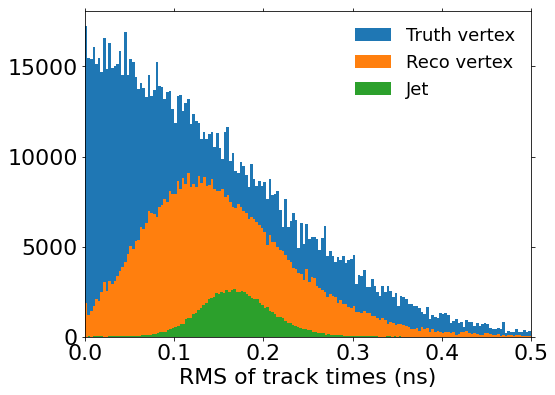

In [96]:
t_range = 0.5

_ = plt.hist(trv_rms_ts_flat[np.abs(trv_rms_ts_flat) < t_range], bins = 170, label='Truth vertex')
_ = plt.hist(rev_rms_ts_flat[np.abs(rev_rms_ts_flat) < t_range], bins = 170, label='Reco vertex')
_ = plt.hist(jet_rms_ts_flat[np.abs(jet_rms_ts_flat) < t_range], bins = 170, label='Jet')

plt.xlabel('RMS of track times (ns)')
plt.xlim(0, t_range)
plt.legend(frameon=False)

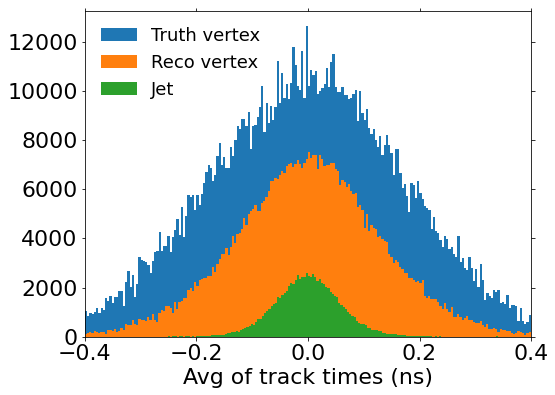

In [132]:
t_range = 0.4

_ = plt.hist(trv_avg_ts_flat[np.abs(trv_avg_ts_flat) < t_range], bins = 200, label='Truth vertex')
_ = plt.hist(rev_avg_ts_flat[np.abs(rev_avg_ts_flat) < t_range], bins = 200, label='Reco vertex')
_ = plt.hist(jet_avg_ts_flat[np.abs(jet_avg_ts_flat) < t_range], bins = 200, label='Jet')

plt.xlabel('Avg of track times (ns)')
plt.xlim(-t_range, t_range)
plt.legend(frameon=False)

Text(0, 0.5, 'Truth vertex RMS track t (ns)')

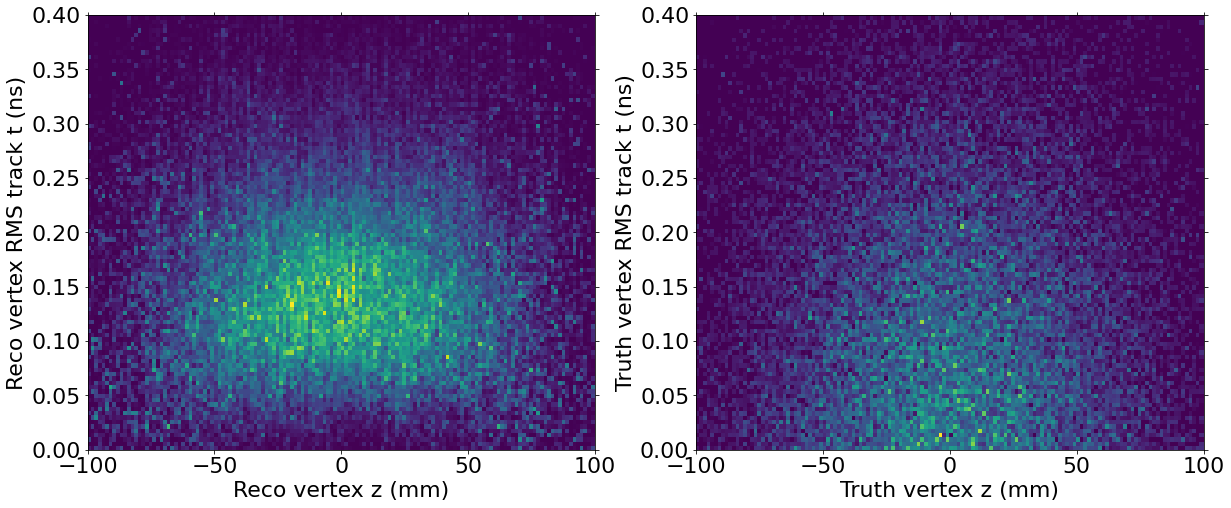

In [125]:
t_range = 0.4
z_range = 100
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)


re_rms_idxs = rev_rms_ts_flat < t_range
re_z_idxs = np.abs(rev_stat_z_flat) < z_range
re_idxs = np.logical_and(re_rms_idxs, re_z_idxs)

_ = ax1.hist2d(rev_stat_z_flat[re_idxs], rev_rms_ts_flat[re_idxs], bins=(140, 100))


tr_rms_idxs = trv_rms_ts_flat < t_range
tr_z_idxs = np.abs(trv_stat_z_flat) < z_range

tr_idxs = np.logical_and(tr_rms_idxs, tr_z_idxs)

_ = ax2.hist2d(trv_stat_z_flat[tr_idxs], trv_rms_ts_flat[tr_idxs], bins=(140, 100))


ax1.set_xlim(-z_range, z_range)
ax1.set_ylim(0, t_range)
ax1.set_xlabel('Reco vertex z (mm)')
ax1.set_ylabel('Reco vertex RMS track t (ns)')

ax2.set_xlim(-z_range, z_range)
ax2.set_ylim(0, t_range)
ax2.set_xlabel('Truth vertex z (mm)')
ax2.set_ylabel('Truth vertex RMS track t (ns)')

In [9]:
file = uproot.open("OutDir_1/hist-Rel21sample.root")
tree1 = file['EventTree;1']
track_t = tree1['track_t'].array(library='np')
track_t_flat = flatten_array(track_t)

reco_vertex_track_idxs = tree1['recovertex_tracks_idx'].array(library='np')

avg_ts_old, rms_ts_old = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t)